- Competition: https://www.kaggle.com/competitions/aerial-cactus-identification/overview
- Dataset: https://www.kaggle.com/competitions/aerial-cactus-identification/data
- Code: https://www.kaggle.com/code/shahules/getting-started-with-cnn-and-vgg16
- Deep Learning: https://www.kaggle.com/learn/intro-to-deep-learning

# 1- Introduction

- How to prepare your data to feed to a neural network
- How convolution neural network works
- How to implement cnn in keras
- How to evaluate your results
- How to use keras pretrained network to improve your model
- How to predit and create a submission

## 1-1 Loading required libraries

In [37]:
import pandas as pd
import os, cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from IPython.display import Image
from keras.preprocessing import image
from keras import optimizers
from keras import layers, models
from keras.applications.imagenet_utils import preprocess_input
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

print(os.listdir('/Users/kenny_jung/aiffel/data/aerial_cactus/'))

from matplotlib import rcParams
rcParams['figure.figsize'] = 13, 6 
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] =False
%config InlineBackend.figure_format = 'retina'


['.DS_Store', 'test', 'submission.csv', 'train', 'train.csv', 'sample_submission.csv']


## 1-2 Setting dataset directories

In [2]:
train_dir = '/Users/kenny_jung/aiffel/data/aerial_cactus/train'
test_dir = '/Users/kenny_jung/aiffel/data/aerial_cactus/test'
train = pd.read_csv('/Users/kenny_jung/aiffel/data/aerial_cactus/train.csv')
df_test = pd.read_csv('/Users/kenny_jung/aiffel/data/aerial_cactus/sample_submission.csv')

In [3]:
print(train.head())
print(train.shape)

                                     id  has_cactus
0  0004be2cfeaba1c0361d39e2b000257b.jpg           1
1  000c8a36845c0208e833c79c1bffedd1.jpg           1
2  000d1e9a533f62e55c289303b072733d.jpg           1
3  0011485b40695e9138e92d0b3fb55128.jpg           1
4  0014d7a11e90b62848904c1418fc8cf2.jpg           1
(17500, 2)


In [4]:
print(train.value_counts('has_cactus'))
print(train.value_counts('has_cactus', normalize=True))

has_cactus
1    13136
0     4364
Name: count, dtype: int64
has_cactus
1    0.750629
0    0.249371
Name: proportion, dtype: float64


In [5]:
print(df_test.head())
print(df_test.shape)
print(df_test.value_counts('has_cactus'))


                                     id  has_cactus
0  000940378805c44108d287872b2f04ce.jpg         0.5
1  0017242f54ececa4512b4d7937d1e21e.jpg         0.5
2  001ee6d8564003107853118ab87df407.jpg         0.5
3  002e175c3c1e060769475f52182583d0.jpg         0.5
4  0036e44a7e8f7218e9bc7bf8137e4943.jpg         0.5
(4000, 2)
has_cactus
0.5    4000
Name: count, dtype: int64


<Axes: xlabel='has_cactus', ylabel='Count'>

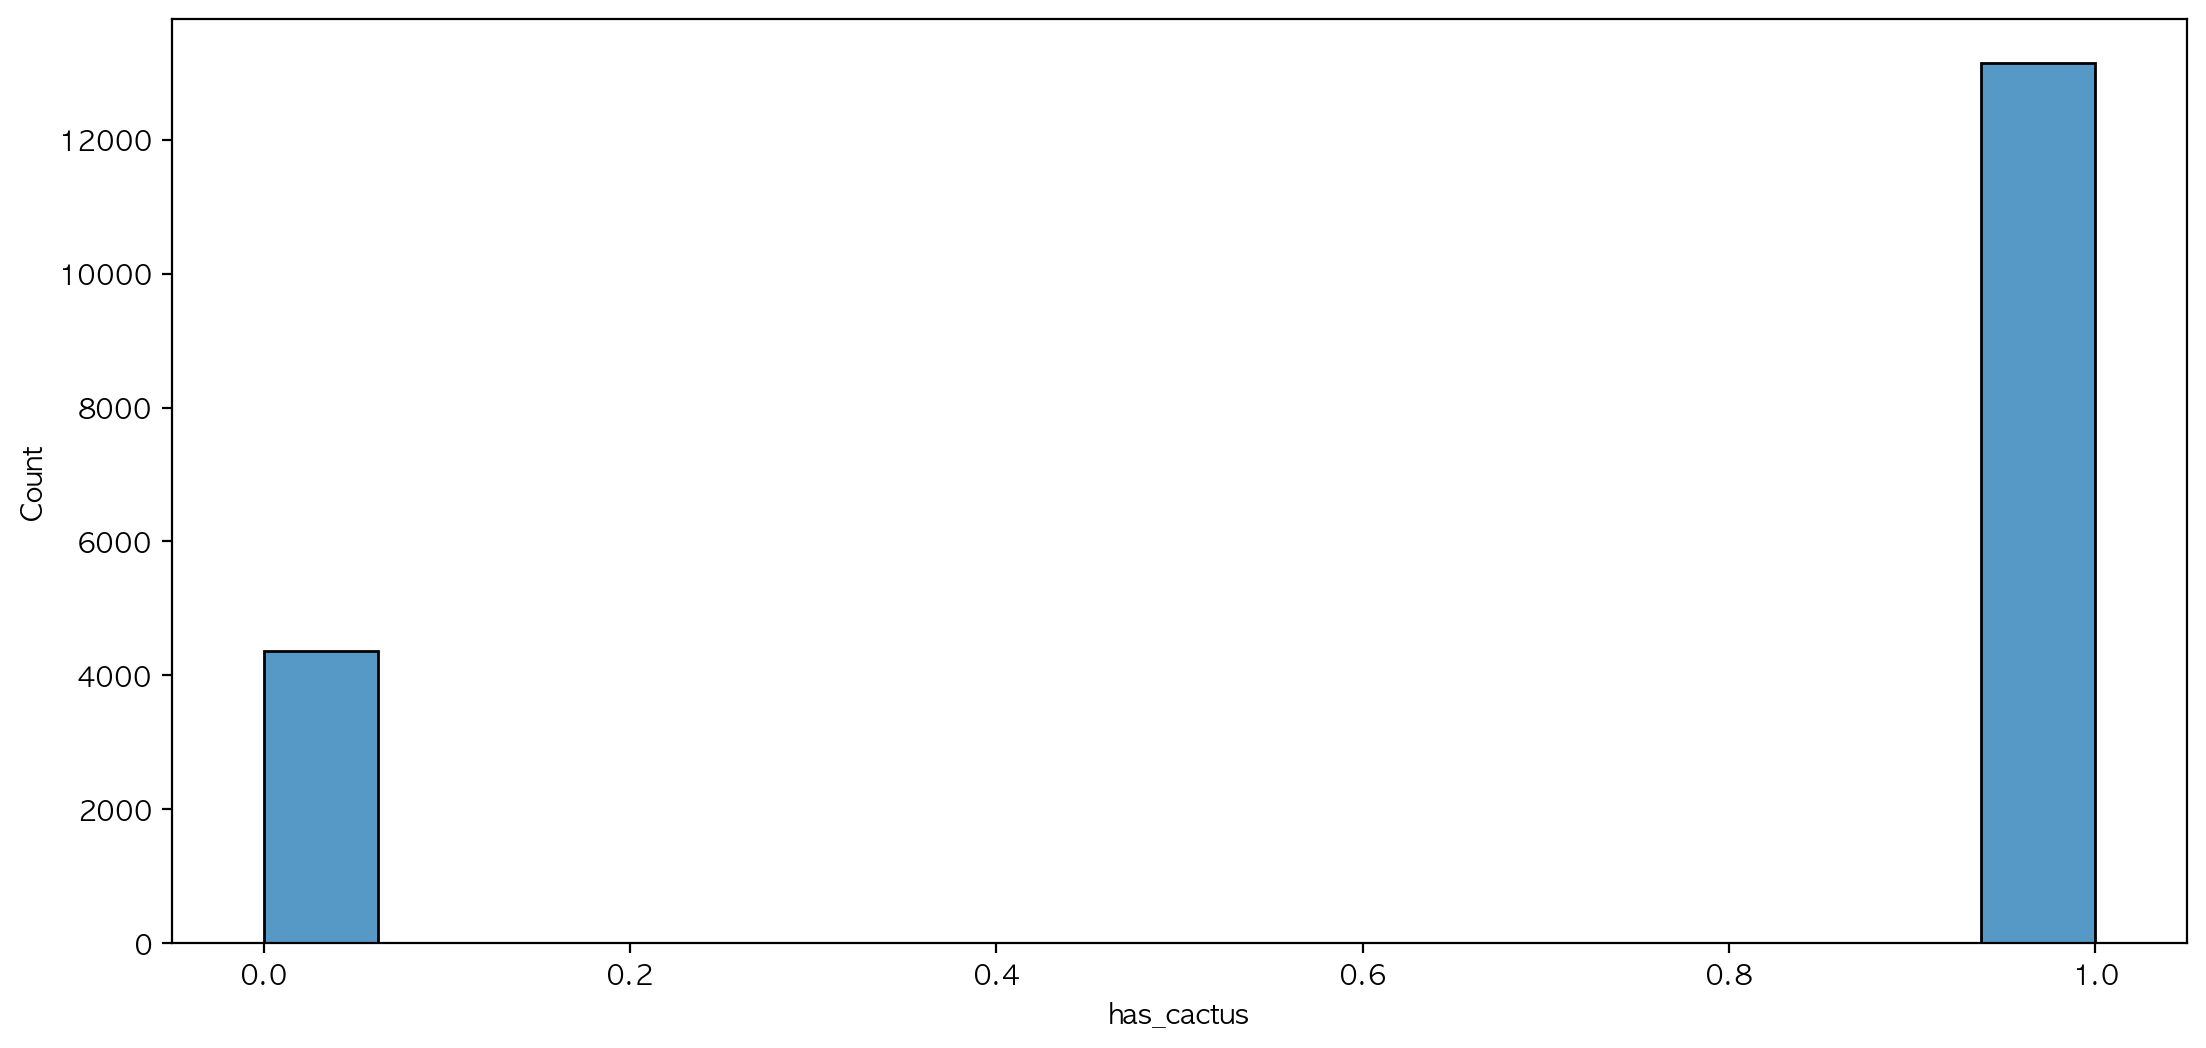

In [6]:
sns.histplot(train['has_cactus'])

## 1-3 Getting a basic idea

In [7]:
train.head(5)
train.has_cactus = train.has_cactus.astype(str)  # Change the data type of the column 'has_cactus' to string

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17500 entries, 0 to 17499
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          17500 non-null  object
 1   has_cactus  17500 non-null  object
dtypes: object(2)
memory usage: 273.6+ KB


In [9]:
print('out dataset has {} rows and {} columns'.format(train.shape[0], train.shape[1]))

out dataset has 17500 rows and 2 columns


In [10]:
train['has_cactus'].value_counts()

has_cactus
1    13136
0     4364
Name: count, dtype: int64

In [11]:
print('The number  of rows in test set is %d'%(len(os.listdir(test_dir))))

The number  of rows in test set is 4000


## 1-4 Displaying image

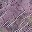

In [12]:
Image(os.path.join(train_dir,train.iloc[3,0]),width=250,height=250)

## 1-5 Data preparation

In [13]:
# Define the parameters of the model
datagen = ImageDataGenerator(rescale = 1./255)  # rescaling images by normalizing the pixel values 
batch_size = 150  # The number of training examples utilized in one iteration

In [14]:
train_generator = datagen.flow_from_dataframe(
    dataframe = train[:15001],  # The first 15000 images are used for training
    directory = train_dir,  # The directory of the training images 
    x_col = 'id',  # The column of the dataframe that contains the filenames of the images
    y_col = 'has_cactus',  # The column of the dataframe that contains the labels of the images 
    class_mode = 'binary',  # The type of the labels
    batch_size = batch_size,  # The number of training examples utilized in one iteration
    target_size = (150, 150)  # The dimensions to which all images found will be resized
)

validation_generator = datagen.flow_from_dataframe(
    dataframe = train[15000:],
    directory = train_dir,
    x_col = 'id',
    y_col = 'has_cactus',
    class_mode = 'binary',
    batch_size = 50,
    target_size = (150, 150)
)

Found 15001 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [15]:
# %pip install tensorflow-macos
# %pip install tensorflow-metal

## 1-6 Building our model

In [16]:
model = models.Sequential()  # The sequential model is a linear stack of layers
model.add(layers.Conv2D(32,  # The number of filters
                        (3, 3),  # The dimensions of the convolution window 
                        activation = 'relu',  # The activation function
                        input_shape = (150, 150, 3)))  # The dimensions of the input images
model.add(layers.MaxPool2D((2,2)))  # The dimensions of the pooling window
model.add(layers.Conv2D(64, 
                        (3, 3),
                        activation = 'relu',
                        input_shape = (150, 150, 3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(128,
                        (3, 3),
                        activation = 'relu',
                        input_shape = (150, 150, 3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(128,
                        (3, 3),
                        activation = 'relu',
                        input_shape = (150, 150, 3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())  # Flattens the input
model.add(layers.Dense(512, activation = 'relu'))  # A densely-connected layer with 512 units
model.add(layers.Dense(1, activation = 'sigmoid'))  # A densely-connected layer with 1 unit


2024-03-05 11:46:51.670702: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-03-05 11:46:51.670725: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-03-05 11:46:51.670735: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-03-05 11:46:51.670766: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-05 11:46:51.670781: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


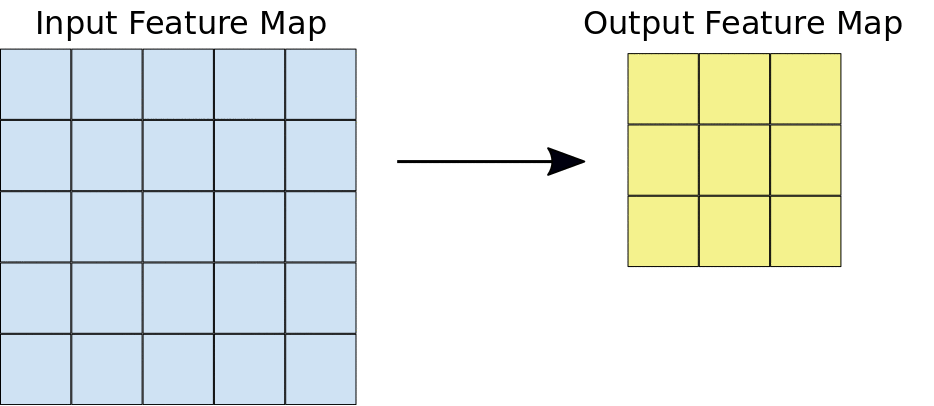

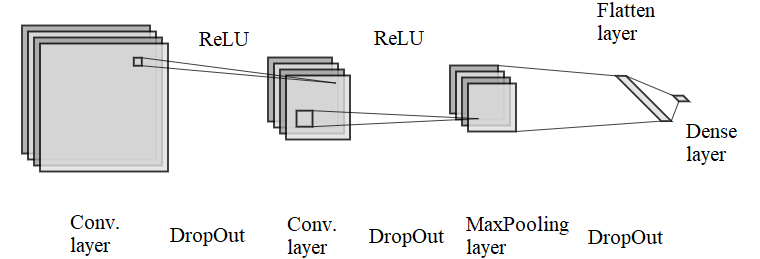

https://www.researchgate.net/figure/The-structure-of-the-CNN-model-two-Convolutional-layers-one-MaxPooling-Flatten-and_fig3_354109692

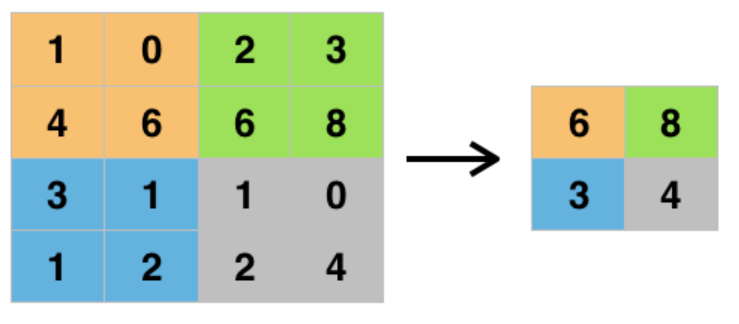

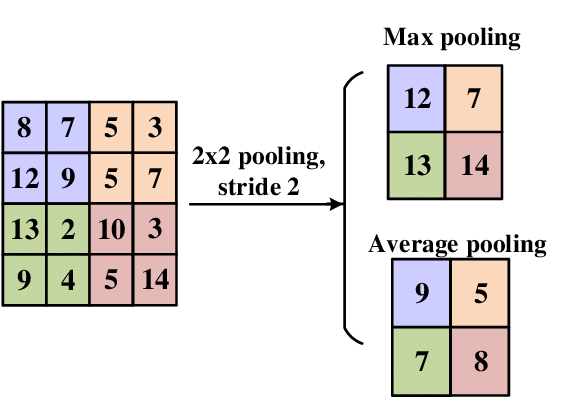

https://www.researchgate.net/figure/Pooling-layer-operation-oproaches-1-Pooling-layers-For-the-function-of-decreasing-the_fig4_340812216

## 1-7 Displaying summary of our network

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

- Conv2D와 MaxPooling2D 레이어는 이미지의 공간적 구조를 이용하여 특징을 추출합니다. Conv2D 레이어는 입력 이미지에 작은 필터를 적용하여 특징 맵을 생성하고, MaxPooling2D 레이어는 특징 맵의 크기를 줄이고 중요한 특징을 강조합니다.
- Flatten 레이어는 2D 특징 맵을 1D 벡터로 변환합니다. 이렇게 하면 Dense 레이어에서 처리할 수 있습니다.
- Dense 레이어는 완전히 연결된 레이어로, 모든 입력 노드가 모든 출력 노드에 연결되어 있습니다. 이 레이어는 모델의 마지막 부분에서 분류 결정을 만드는 데 사용됩니다.
- Param #는 각 레이어의 가중치와 편향의 수를 나타냅니다. 이는 모델의 크기와 복잡성을 나타내는 지표입니다.
- Total params는 모델의 전체 파라미터 수를 나타냅니다. 이 모델은 총 3,453,121개의 파라미터를 가지고 있습니다.
- Trainable params는 훈련 중에 업데이트될 수 있는 파라미터의 수를 나타냅니다. 이 모델에서는 모든 파라미터가 훈련 가능합니다.
- Non-trainable params는 훈련 중에 업데이트되지 않는 파라미터의 수를 나타냅니다. 이 모델에서는 훈련 불가능한 파라미터가 없습니다.

In [18]:
#!pip install pydot
#!pip install graphviz

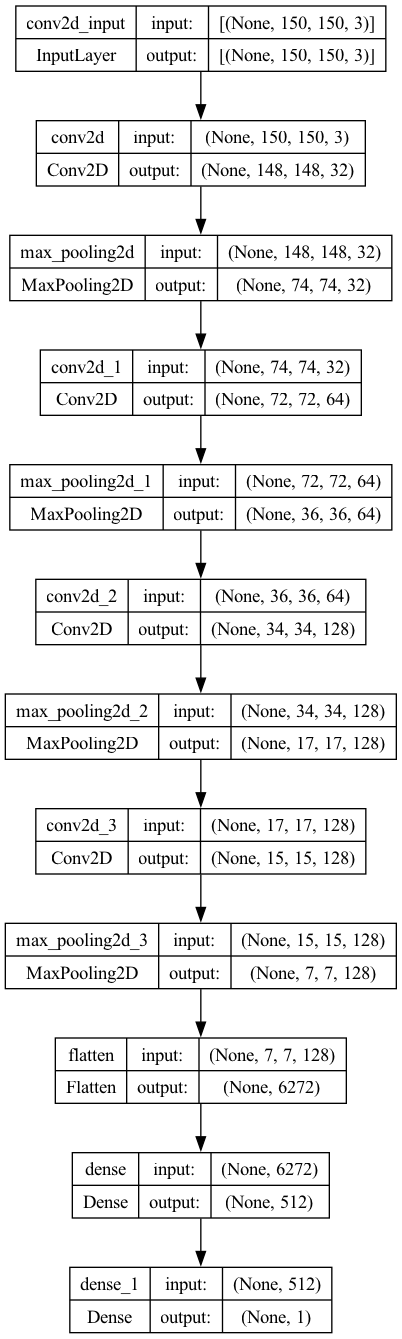

In [19]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

## Compiling our model

In [20]:
# Compile the model with optimizer RMSprop (suboptimal to M1)
model.compile(loss = 'binary_crossentropy',  # The loss function
             optimizer = optimizers.RMSprop(),  # The optimizer
             metrics = ['acc'])  # The metric to monitor

In [21]:
# # Compile the model with optimizer 
# import tensorflow as tf 
# optimizer = tf.keras.optimizers.legacy.RMSprop()  # Legacy 버전 불러오기
# model.compile(loss = 'binary_crossentropy',  # The loss function
#              optimizer = optimizer,  # The optimizer
#              metrics = ['acc'])          # 모델 compiling

## Fitting our model

In [22]:
epochs = 10  # The number of epochs
history = model.fit(train_generator,  # The training data
                    steps_per_epoch = 100,  # The number of batches to yield from the generator in one epoch
                    epochs = 10,  # The number of epochs
                    validation_data = validation_generator,  # The validation data
                    validation_steps = 50  # The number of batches to yield from the generator in one epoch 
)

Epoch 1/10


2024-03-05 11:46:52.657072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 9s 83ms/step - loss: 0.4699 - acc: 0.8015 - val_loss: 0.2370 - val_acc: 0.9268
Epoch 2/10
100/100 [==============================] - 8s 76ms/step - loss: 0.6296 - acc: 0.8274 - val_loss: 0.7043 - val_acc: 0.4448
Epoch 3/10
100/100 [==============================] - 8s 77ms/step - loss: 0.5871 - acc: 0.8360 - val_loss: 1.0169 - val_acc: 0.4016
Epoch 4/10
100/100 [==============================] - 8s 77ms/step - loss: 1.1547 - acc: 0.8830 - val_loss: 12.5502 - val_acc: 0.7632
Epoch 5/10
100/100 [==============================] - 8s 77ms/step - loss: 6.5641 - acc: 0.8008 - val_loss: 5.8562 - val_acc: 0.7788
Epoch 6/10
100/100 [==============================] - 8s 77ms/step - loss: 4.0424 - acc: 0.8001 - val_loss: 3.0669 - val_acc: 0.7692
Epoch 7/10
100/100 [==============================] - 8s 77ms/step - loss: 4.7820 - acc: 0.7713 - val_loss: 6.8830 - val_acc: 0.7348
Epoch 8/10
100/100 [==============================] - 8s 76ms/step - loss: 2.55

## Evaluating our model

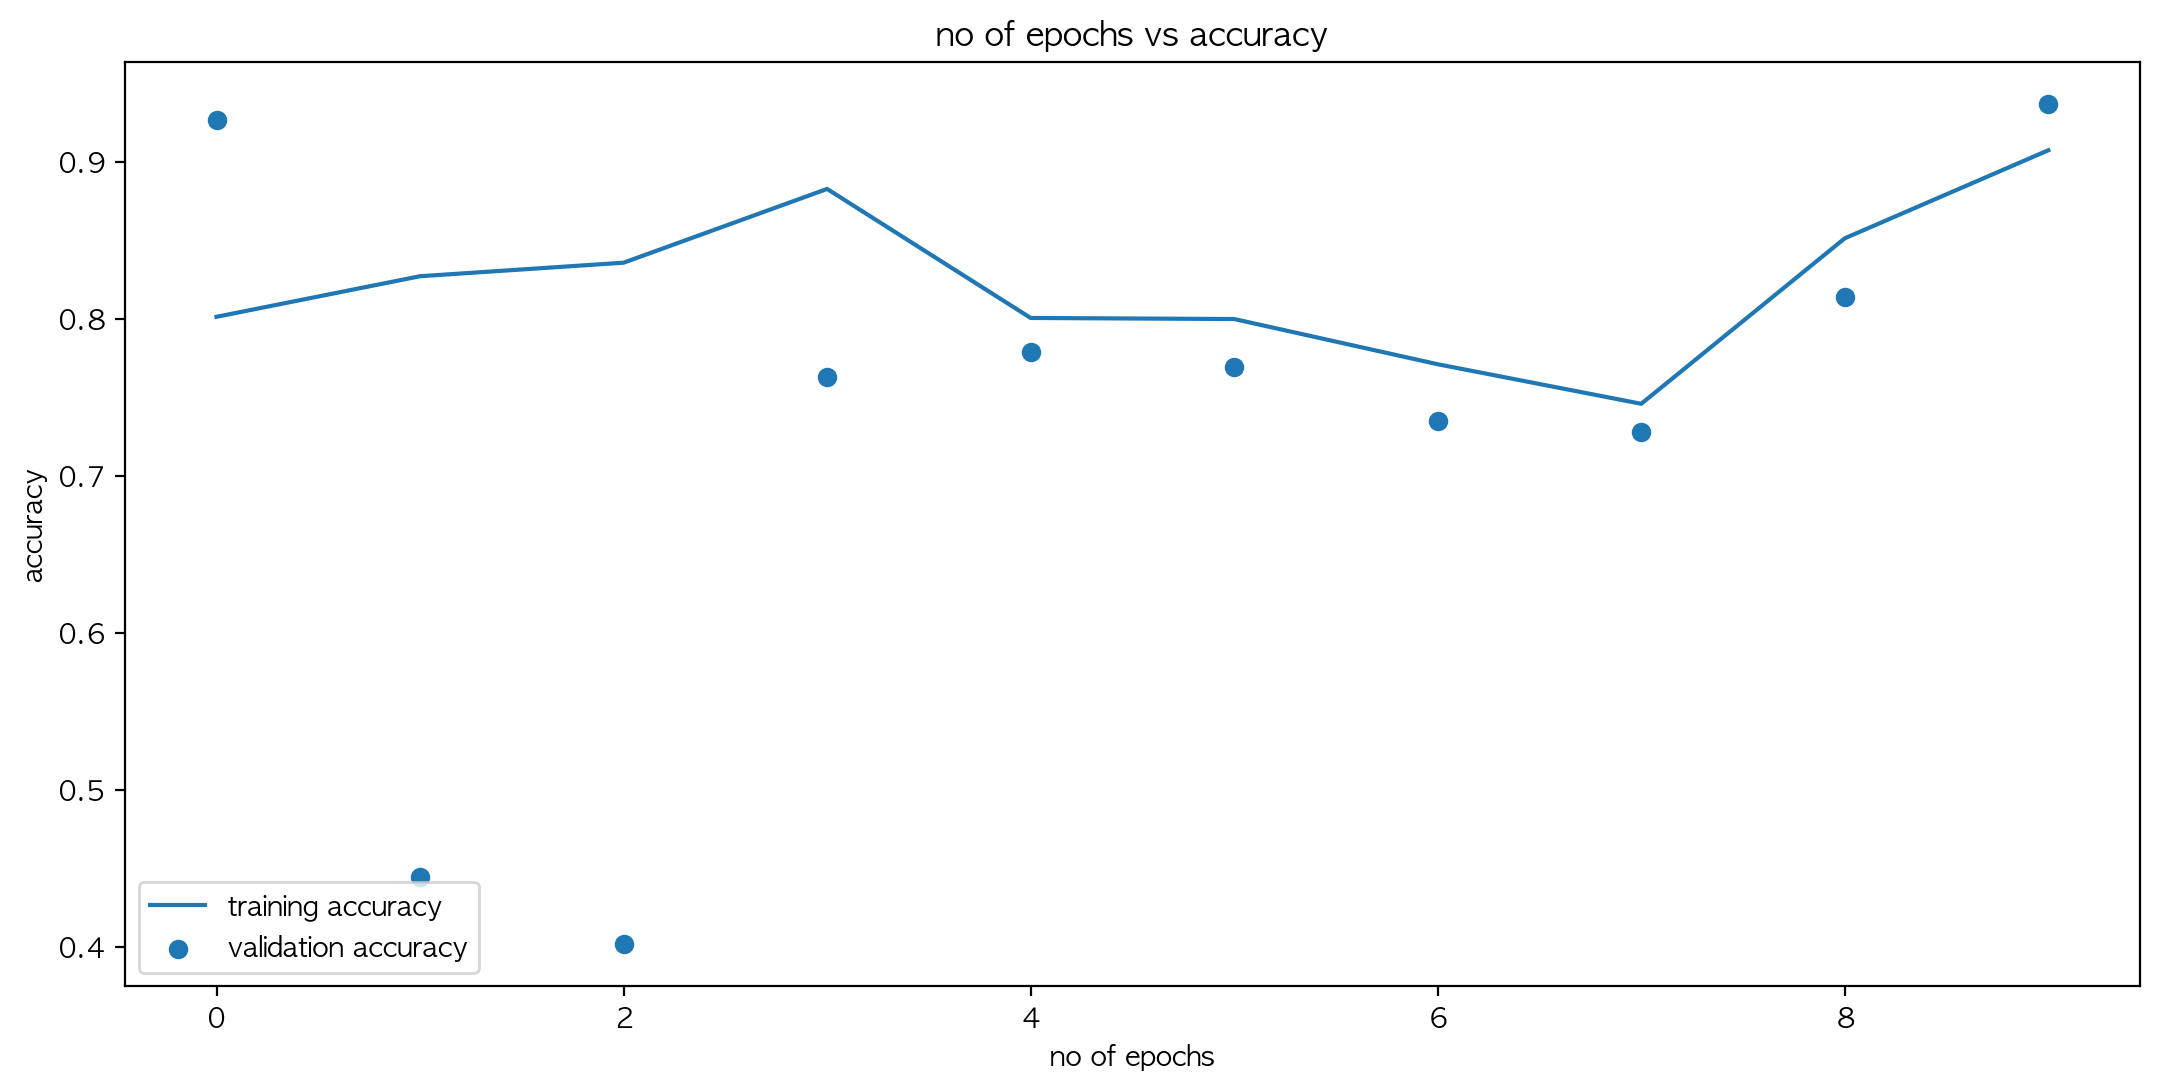

In [23]:
acc=history.history['acc']  ##getting  accuracy of each epochs
epochs_=range(0,epochs)    
plt.plot(epochs_,acc,label='training accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

acc_val=history.history['val_acc']  ##getting validation accuracy of each epochs
plt.scatter(epochs_,acc_val,label="validation accuracy")
plt.title("no of epochs vs accuracy")
plt.legend()

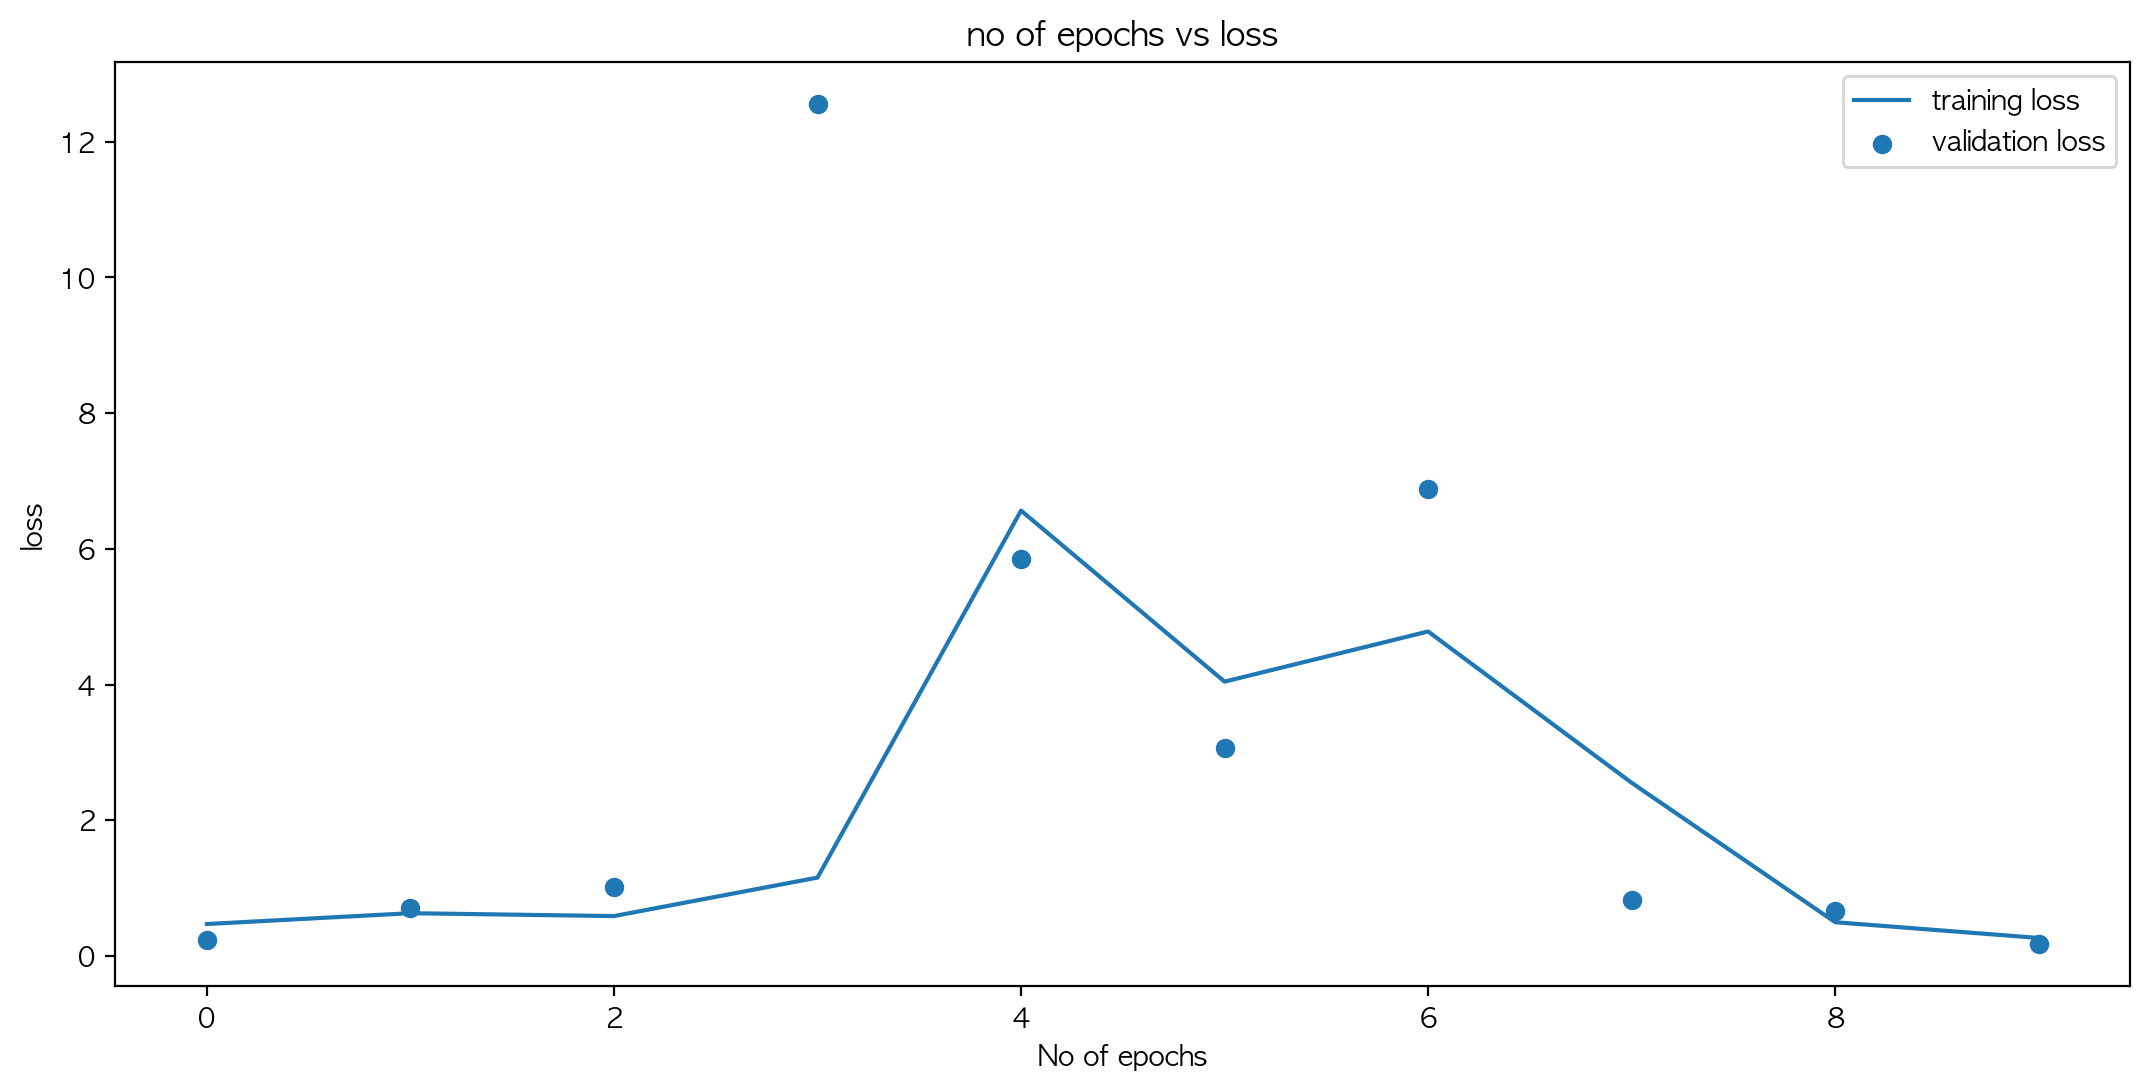

In [24]:
acc=history.history['loss']    ##getting  loss of each epochs
epochs_=range(0,epochs)
plt.plot(epochs_,acc,label='training loss')
plt.xlabel('No of epochs')
plt.ylabel('loss')

acc_val=history.history['val_loss']  ## getting validation loss of each epochs
plt.scatter(epochs_,acc_val,label="validation loss")
plt.title('no of epochs vs loss')
plt.legend()

## Improving our model using VGG16

In [25]:
model_vg=VGG16(weights='imagenet',include_top=False)
model_vg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## Extracting features using VGG16

In [26]:
def extract_features(directory,samples,df):
    
    
    features=np.zeros(shape=(samples,4,4,512))
    labels=np.zeros(shape=(samples))
    generator=datagen.flow_from_dataframe(dataframe=df,directory=directory,x_col='id',
                                            y_col='has_cactus',class_mode='other',batch_size=batch_size,
                                            target_size=(150,150))
    i=0
    for input_batch,label_batch in generator:
        feature_batch=model_vg.predict(input_batch)
        features[i*batch_size:(i+1)*batch_size]=feature_batch
        labels[i*batch_size:(i+1)*batch_size]=label_batch
        i+=1
        if(i*batch_size>samples):
            break
    return(features,labels)

train.has_cactus=train.has_cactus.astype(int)
features,labels=extract_features(train_dir,17500,train)
train_features=features[:15001]
train_labels=labels[:15001]

validation_features=features[15000:]
validation_labels=labels[15000:]

Found 17500 validated image filenames.
4/4 [==============================] - 0s 62ms/step


## Reshaping our features to feed into our dense layers

In [27]:
#df_test.has_cactus=df_test.has_cactus.astype(str)
test_features,test_labels=extract_features(test_dir,4000,df_test)

Found 4000 validated image filenames.


4/4 [==============================] - 0s 48ms/step


In [28]:
train_features=train_features.reshape((15001,4*4*512))
validation_features=validation_features.reshape((2500,4*4*512))

test_features=test_features.reshape((4000,4*4*512))

## Define a densely connected network

In [29]:
model=models.Sequential()
model.add(layers.Dense(
    212,activation='relu',
    kernel_regularizer=regularizers.l1_l2(.001),
    input_dim=(4*4*512))
)
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1,activation='sigmoid'))

In [32]:
model.compile(
    optimizer=optimizers.RMSprop(),
    loss='binary_crossentropy',
    metrics=['acc']
)

In [33]:
history=model.fit(
    train_features,
    train_labels,
    epochs=30,
    batch_size=15,
    validation_data=(validation_features, validation_labels)
)

Epoch 1/30
1001/1001 [==============================] - 18s 17ms/step - loss: 1.4282 - acc: 0.9003 - val_loss: 1.0743 - val_acc: 0.9384
Epoch 2/30
1001/1001 [==============================] - 16s 16ms/step - loss: 1.0735 - acc: 0.9390 - val_loss: 1.0153 - val_acc: 0.9584
Epoch 3/30
1001/1001 [==============================] - 16s 16ms/step - loss: 1.0389 - acc: 0.9469 - val_loss: 0.9997 - val_acc: 0.9636
Epoch 4/30
1001/1001 [==============================] - 17s 17ms/step - loss: 1.0174 - acc: 0.9517 - val_loss: 0.9758 - val_acc: 0.9688
Epoch 5/30
1001/1001 [==============================] - 16s 16ms/step - loss: 1.0090 - acc: 0.9537 - val_loss: 1.2709 - val_acc: 0.8292
Epoch 6/30
1001/1001 [==============================] - 17s 17ms/step - loss: 1.0028 - acc: 0.9527 - val_loss: 0.9638 - val_acc: 0.9712
Epoch 7/30
1001/1001 [==============================] - 17s 17ms/step - loss: 0.9914 - acc: 0.9545 - val_loss: 0.9871 - val_acc: 0.9536
Epoch 8/30
1001/1001 [==========================

## Making prediction

In [35]:
y_pre = model.predict(test_features)


125/125 [==============================] - 0s 2ms/step


## Making a submission

In [36]:
df = pd.DataFrame({'id': df_test['id']})
df['has_cactus'] = y_pre
df.to_csv('/Users/kenny_jung/aiffel/data/aerial_cactus/submission.csv', index=False)